In [ ]:
!pip install gensim
# Import the gensim downloader api

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api

In [ ]:
#Load IMDB data
vocab_size = 10000
max_length = 200
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

In [ ]:
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 25000
Testing samples: 25000


In [ ]:
# Convert word indices back to raw text for TF-IDF
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
X_train_text = [' '.join([reverse_word_index.get(i - 3, '?') for i in seq]) for seq in X_train]
X_test_text = [' '.join([reverse_word_index.get(i - 3, '?') for i in seq]) for seq in X_test]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test_text).toarray()

# Word2Vec preprocessing
X_train_w2v = pad_sequences(X_train, maxlen=max_length)
X_test_w2v = pad_sequences(X_test, maxlen=max_length)

# Load pre-trained Word2Vec and build embedding matrix with normalization
word2vec = api.load("word2vec-google-news-300")
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        word_normalized = word.lower()  # Normalize to lowercase
        try:
            embedding_matrix[i + 1] = word2vec[word_normalized]
        except KeyError:
            pass

# Verify coverage and embeddings
covered = sum(1 for i in range(vocab_size) if np.any(embedding_matrix[i + 1]))
print(f"Word2Vec coverage after normalization: {covered / vocab_size:.2%}")
print("Embedding for 'the' (index 1):", embedding_matrix[1][:10], "...")  # Verify non-zero values

# Average Word2Vec embeddings for an alternative input (300D)
X_train_w2v_avg = np.mean([embedding_matrix[seq] for seq in X_train_w2v], axis=1)
X_test_w2v_avg = np.mean([embedding_matrix[seq] for seq in X_test_w2v], axis=1)

# Print number of samples
print(f"Number of training samples: {X_train_w2v.shape[0]}")
print(f"Number of testing samples: {X_test_w2v.shape[0]}")

# Categories
cats = ['Negative', 'Positive']

Word2Vec coverage after normalization: 92.85%
Embedding for 'the' (index 1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...


In [ ]:
covered = sum(1 for i in range(vocab_size) if np.any(embedding_matrix[i + 1]))
print(f"Word2Vec coverage: {covered / vocab_size:.2%}")

Word2Vec coverage: 92.85%


In [ ]:
print(embedding_matrix[1])  # Should be the embedding for "the" (index 1 in IMDB)
print(embedding_matrix[0])  # Should be all zeros (padding)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

In [ ]:
print(X_train_w2v[0][:10])  # First 10 tokens of the first review

[  5  25 100  43 838 112  50 670   2   9]


In [ ]:
# Function to build and train ANN
def build_and_train_ann(X_train, X_test, y_train, y_test, config_name,
                        use_dropout=False, use_weight_decay=False, use_batch_norm=False,
                        use_early_stopping=False, use_embedding=False, use_lstm=False, use_avg_w2v=False):


    model = Sequential()
    if use_embedding and not use_avg_w2v:
        # Use sequence input with Embedding layer
        model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=max_length, trainable=True))
        if use_lstm:
            model.add(LSTM(128, return_sequences=False))  # Output (None, 128)
        else:
            model.add(Flatten())  # Output (None, 60000)
        model.add(Dense(128, activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.001) if use_weight_decay else None))
    else:  # TF-IDF
        model.add(Dense(128, input_dim=X_train.shape[1], activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.001) if use_weight_decay else None))

    if use_batch_norm:
        model.add(BatchNormalization())
    if use_dropout:
        model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001) if use_weight_decay else None))
    if use_batch_norm:
        model.add(BatchNormalization())
    if use_dropout:
        model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = []
    if use_early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        callbacks.append(early_stopping)

    history = model.fit(X_train, y_train, epochs=5, batch_size=32,
                        validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    final_train_acc = history.history['accuracy'][-1]

    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=cats))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{config_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{config_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cats, yticklabels=cats)
    plt.title(f'Confusion Matrix - {config_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return final_train_acc, test_acc, y_pred, model



In [ ]:
# Test configurations for TF-IDF and Word2Vec
configs = [
    ("Baseline TF-IDF", X_train_tfidf, X_test_tfidf, False, False, False, False, False),
    ("TF-IDF with Early Stopping", X_train_tfidf, X_test_tfidf, False, False, False, True, False),
    ("TF-IDF with Dropout", X_train_tfidf, X_test_tfidf, True, False, False, False, False),
    ("TF-IDF with Weight Decay", X_train_tfidf, X_test_tfidf, False, True, False, False, False),
    ("TF-IDF with Batch Norm", X_train_tfidf, X_test_tfidf, False, False, True, False, False),
    ("Baseline Word2Vec", X_train_w2v, X_test_w2v, False, False, False, False, True),
    ("Word2Vec with Early Stopping", X_train_w2v, X_test_w2v, False, False, False, True, True),
    ("Word2Vec with Dropout", X_train_w2v, X_test_w2v, True, False, False, False, True),
    ("Word2Vec with Weight Decay", X_train_w2v, X_test_w2v, False, True, False, False, True),
    ("Word2Vec with Batch Norm", X_train_w2v, X_test_w2v, False, False, True, False, True),
]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8250 - loss: 0.4035 - val_accuracy: 0.8782 - val_loss: 0.2859
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.9242 - loss: 0.1974 - val_accuracy: 0.8704 - val_loss: 0.3239
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.9421 - loss: 0.1514 - val_accuracy: 0.8692 - val_loss: 0.3319
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.9725 - loss: 0.0823 - val_accuracy: 0.8632 - val_loss: 0.4386
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.9917 - loss: 0.0253 - val_accuracy: 0.8621 - val_loss: 0.6122
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.9987 - loss: 0.0069 - val_accuracy: 0.8613 - val_loss: 0.8400
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8595 - val_loss: 0.9413
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 1.0000 - loss: 6.2793e-0

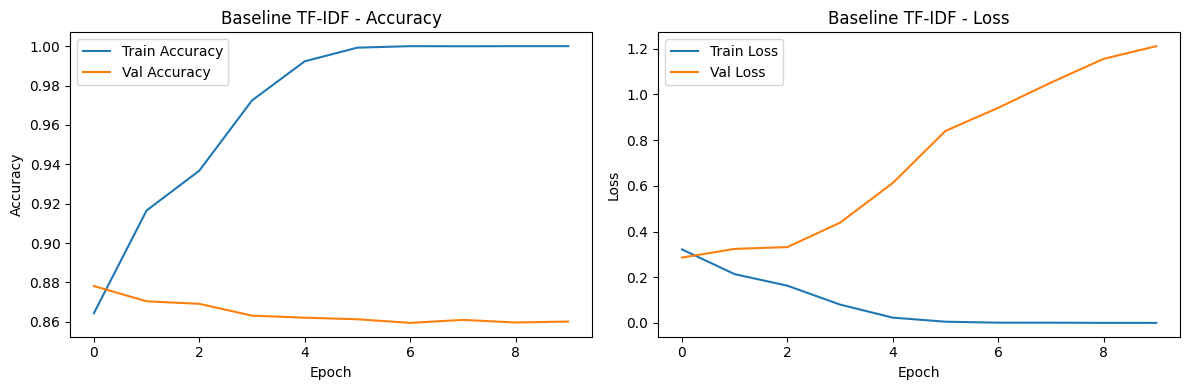

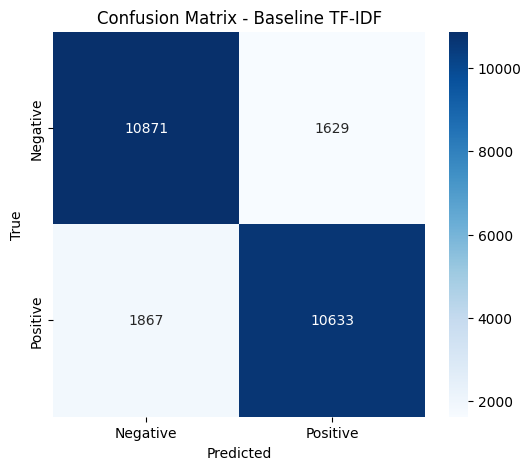

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8312 - loss: 0.4020 - val_accuracy: 0.8702 - val_loss: 0.3025
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9241 - loss: 0.1984 - val_accuracy: 0.8710 - val_loss: 0.3023
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9445 - loss: 0.1504 - val_accuracy: 0.8692 - val_loss: 0.3347
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9689 - loss: 0.0873 - val_accuracy: 0.8629 - val_loss: 0.4357
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9935 - loss: 0.0252 - val_accuracy: 0.8589 - val_loss: 0.6481
Final Training Accuracy: 0.9936
Test Accuracy: 0.8710
Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87     12500
    Positive       0.89      0.85      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
w

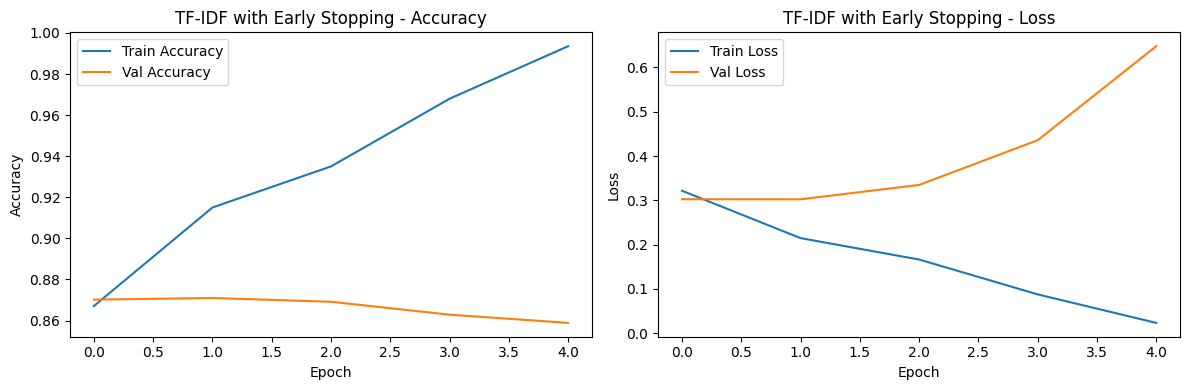

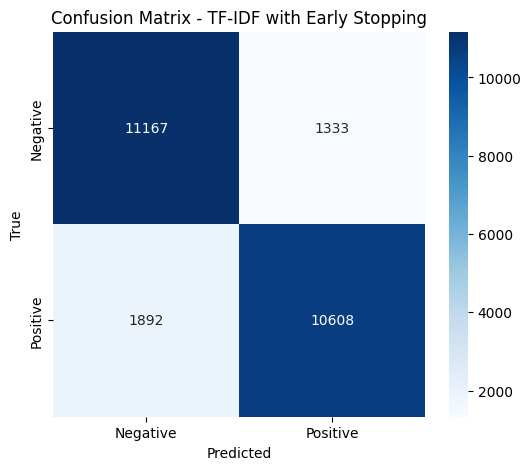

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.7798 - loss: 0.4663 - val_accuracy: 0.8849 - val_loss: 0.2759
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9156 - loss: 0.2160 - val_accuracy: 0.8762 - val_loss: 0.2932
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9388 - loss: 0.1656 - val_accuracy: 0.8736 - val_loss: 0.3167
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9577 - loss: 0.1258 - val_accuracy: 0.8672 - val_loss: 0.3512
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9721 - loss: 0.0870 - val_accuracy: 0.8670 - val_loss: 0.4157
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9799 - loss: 0.0614 - val_accuracy: 0.8663 - val_loss: 0.5053
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9867 - loss: 0.0416 - val_accuracy: 0.8649 - val_loss: 0.5402
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9886 - loss: 0.0331 - 

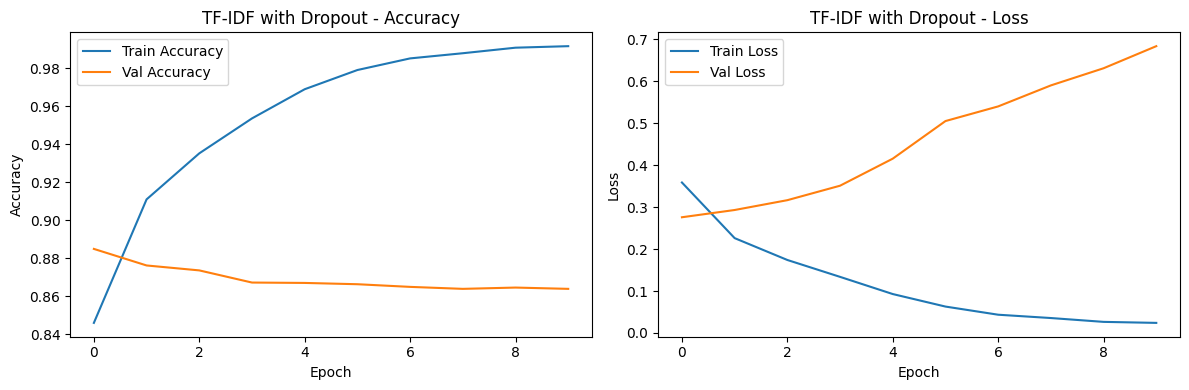

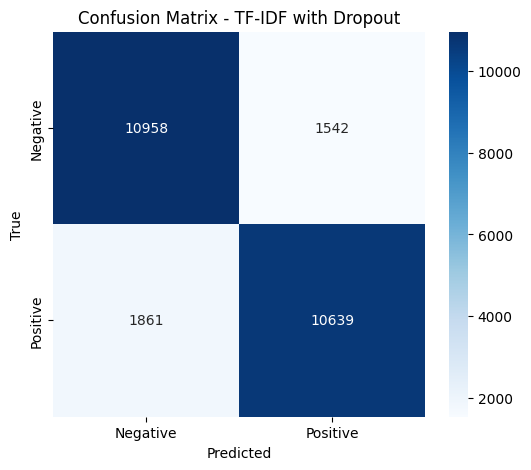

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.7431 - loss: 1.0184 - val_accuracy: 0.8323 - val_loss: 0.6044
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8573 - loss: 0.5700 - val_accuracy: 0.8458 - val_loss: 0.5494
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8645 - loss: 0.5175 - val_accuracy: 0.8656 - val_loss: 0.5016
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8728 - loss: 0.4850 - val_accuracy: 0.8706 - val_loss: 0.4748
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.8790 - loss: 0.4594 - val_accuracy: 0.8749 - val_loss: 0.4558
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8863 - loss: 0.4352 - val_accuracy: 0.8737 - val_loss: 0.4423
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8895 - loss: 0.4234 - val_accuracy: 0.8554 - val_loss: 0.4587
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8938 - loss: 0.4033 - 

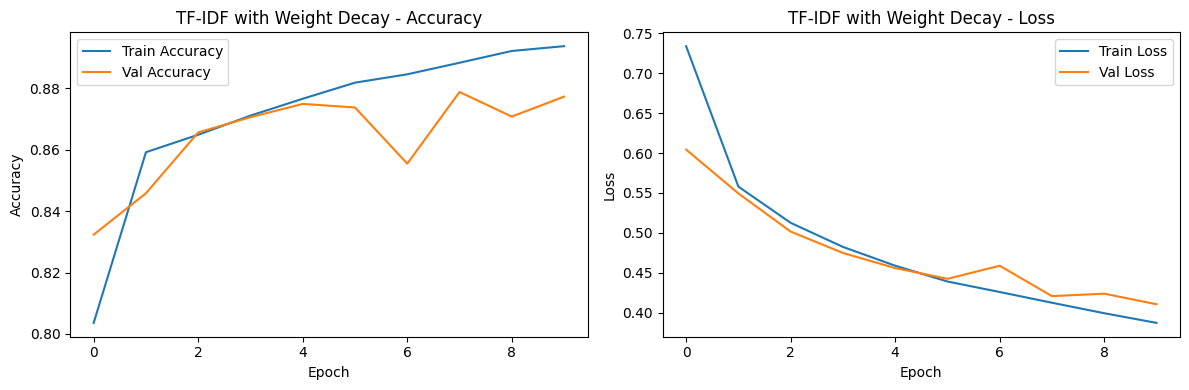

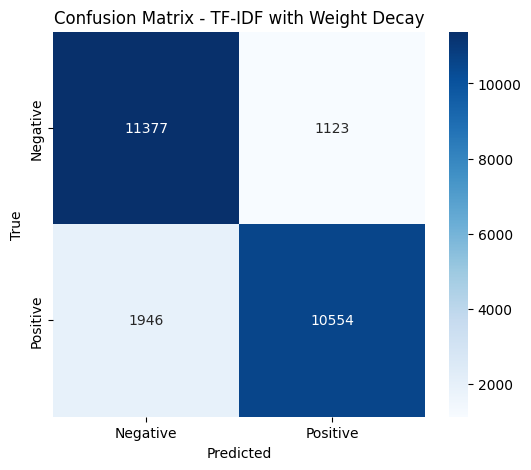

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8143 - loss: 0.3980 - val_accuracy: 0.8743 - val_loss: 0.2931
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9404 - loss: 0.1653 - val_accuracy: 0.8587 - val_loss: 0.3507
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9731 - loss: 0.0770 - val_accuracy: 0.8520 - val_loss: 0.4718
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9876 - loss: 0.0388 - val_accuracy: 0.8561 - val_loss: 0.5191
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9897 - loss: 0.0298 - val_accuracy: 0.8543 - val_loss: 0.5996
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9865 - loss: 0.0379 - val_accuracy: 0.8510 - val_loss: 0.6570
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9923 - loss: 0.0236 - val_accuracy: 0.8527 - val_loss: 0.6513
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9922 - loss: 0.0265 - 

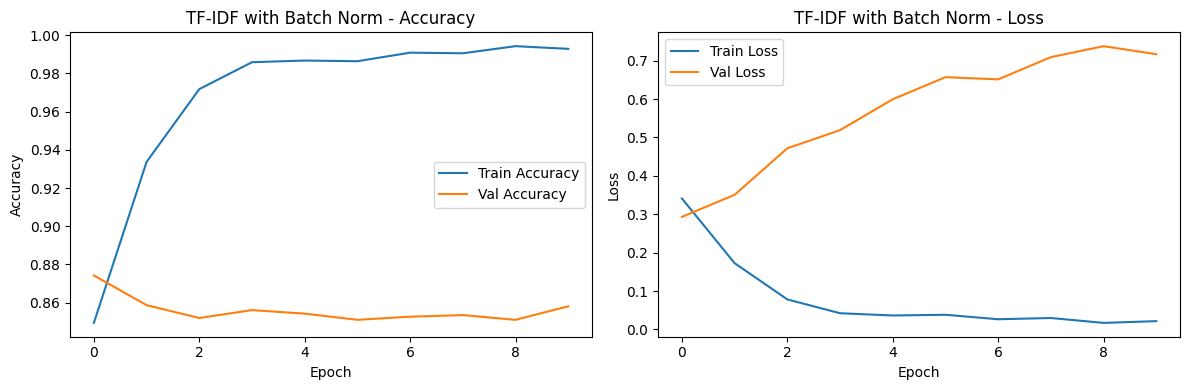

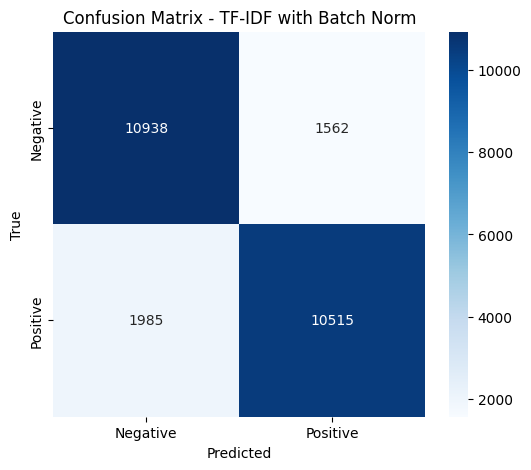

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 121ms/step - accuracy: 0.5427 - loss: 0.6944 - val_accuracy: 0.6167 - val_loss: 0.6515
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 104s 133ms/step - accuracy: 0.7822 - loss: 0.4717 - val_accuracy: 0.6249 - val_loss: 0.6836
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 128ms/step - accuracy: 0.9196 - loss: 0.2180 - val_accuracy: 0.6201 - val_loss: 0.9704
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 136s 120ms/step - accuracy: 0.9716 - loss: 0.0767 - val_accuracy: 0.6176 - val_loss: 1.4048
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 144s 123ms/step - accuracy: 0.9825 - loss: 0.0474 - val_accuracy: 0.6110 - val_loss: 1.6582
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 149s 133ms/step - accuracy: 0.9860 - loss: 0.0407 - val_accuracy: 0.6206 - val_loss: 2.0584
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 130s 118ms/step - accuracy: 0.9881 - loss: 0.0311 - val_accuracy: 0.6169 - val_loss: 2.0049
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 117ms/step - accuracy: 0.9921 - 

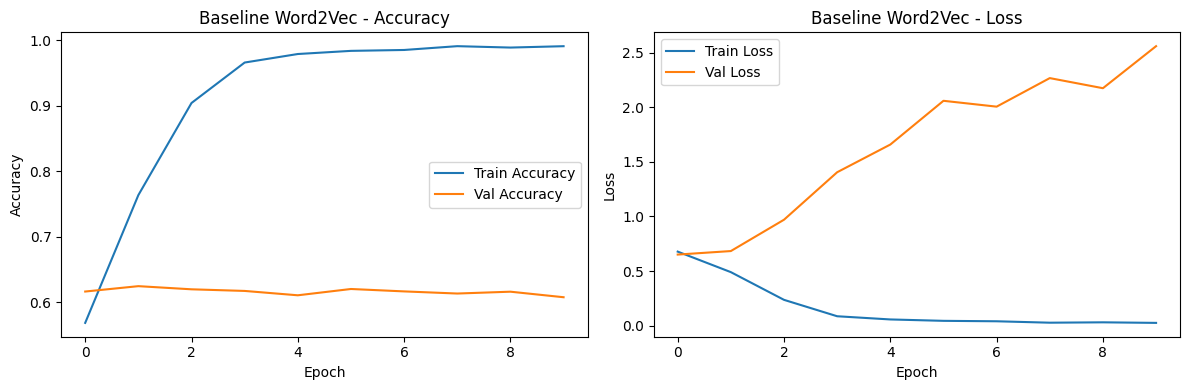

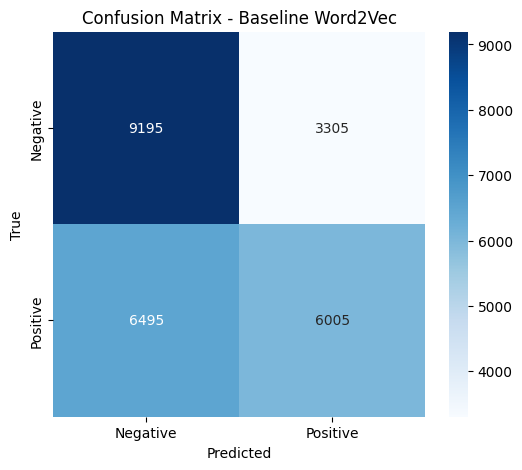

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 107s 135ms/step - accuracy: 0.5398 - loss: 0.6925 - val_accuracy: 0.6168 - val_loss: 0.6509
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 139ms/step - accuracy: 0.7776 - loss: 0.4728 - val_accuracy: 0.6293 - val_loss: 0.6752
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 139ms/step - accuracy: 0.9156 - loss: 0.2231 - val_accuracy: 0.6190 - val_loss: 0.8758
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 133s 128ms/step - accuracy: 0.9711 - loss: 0.0816 - val_accuracy: 0.6147 - val_loss: 1.5167
Final Training Accuracy: 0.9645
Test Accuracy: 0.6168
Classification Report:
              precision    recall  f1-score   support

    Negative       0.64      0.54      0.58     12500
    Positive       0.60      0.70      0.64     12500

    accuracy                           0.62     25000
   macro avg       0.62      0.62      0.61     25000
weighted avg       0.62      0.62      0.61     25000



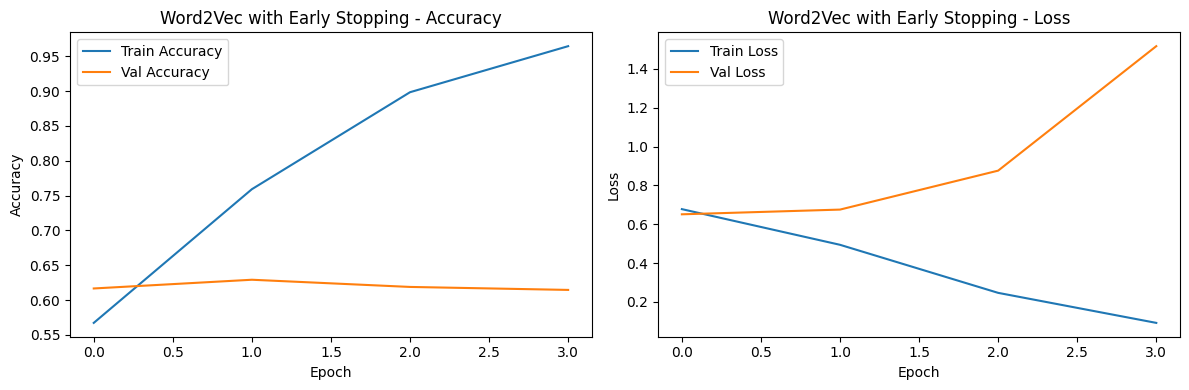

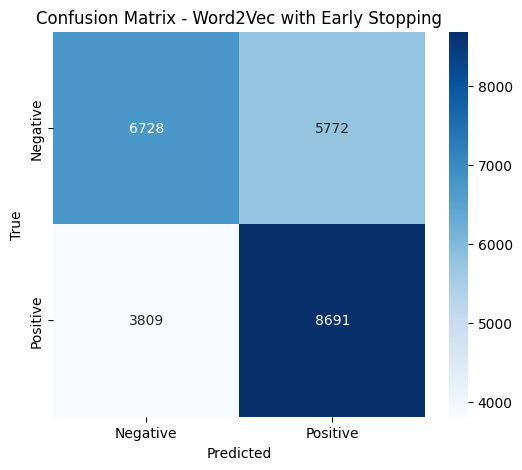

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 120ms/step - accuracy: 0.5056 - loss: 0.7179 - val_accuracy: 0.5026 - val_loss: 0.6931
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 148s 128ms/step - accuracy: 0.5107 - loss: 0.6944 - val_accuracy: 0.5040 - val_loss: 0.6930
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 129ms/step - accuracy: 0.5125 - loss: 0.6895 - val_accuracy: 0.5091 - val_loss: 0.6926
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 133s 118ms/step - accuracy: 0.5315 - loss: 0.6778 - val_accuracy: 0.5129 - val_loss: 0.6919
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 99s 127ms/step - accuracy: 0.5529 - loss: 0.6633 - val_accuracy: 0.5167 - val_loss: 0.6919
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 137s 120ms/step - accuracy: 0.5673 - loss: 0.6447 - val_accuracy: 0.5282 - val_loss: 0.6908
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 128ms/step - accuracy: 0.5835 - loss: 0.6285 - val_accuracy: 0.5322 - val_loss: 0.6906
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 128ms/step - accuracy: 0.5950 - loss: 0.6116

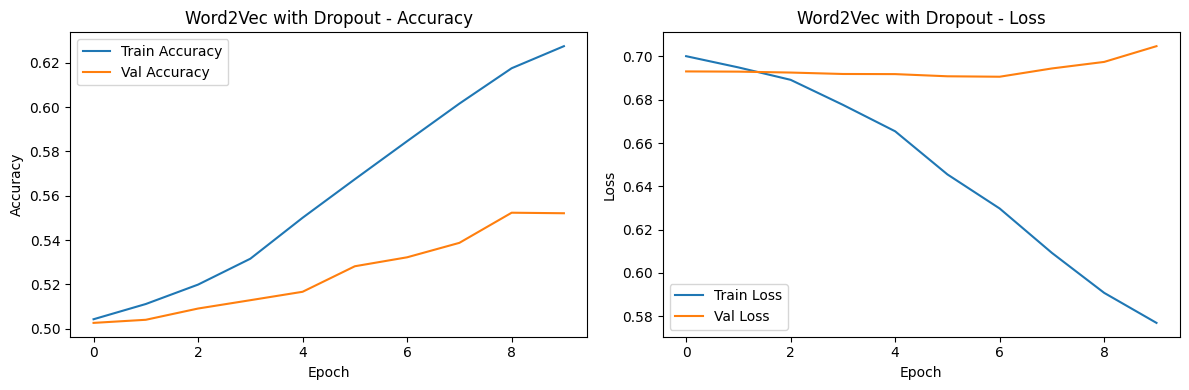

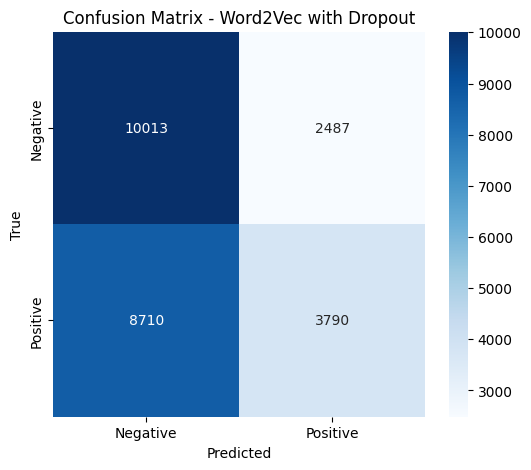

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 120s 150ms/step - accuracy: 0.5182 - loss: 1.3576 - val_accuracy: 0.5000 - val_loss: 0.7324
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 118s 151ms/step - accuracy: 0.5145 - loss: 0.7240 - val_accuracy: 0.5000 - val_loss: 0.6983
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 151ms/step - accuracy: 0.4994 - loss: 0.6990 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 116s 149ms/step - accuracy: 0.4963 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 149ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 117s 150ms/step - accuracy: 0.4985 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 148ms/step - accuracy: 0.5042 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 148ms/step - accuracy: 0.5015 - loss: 0.69

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


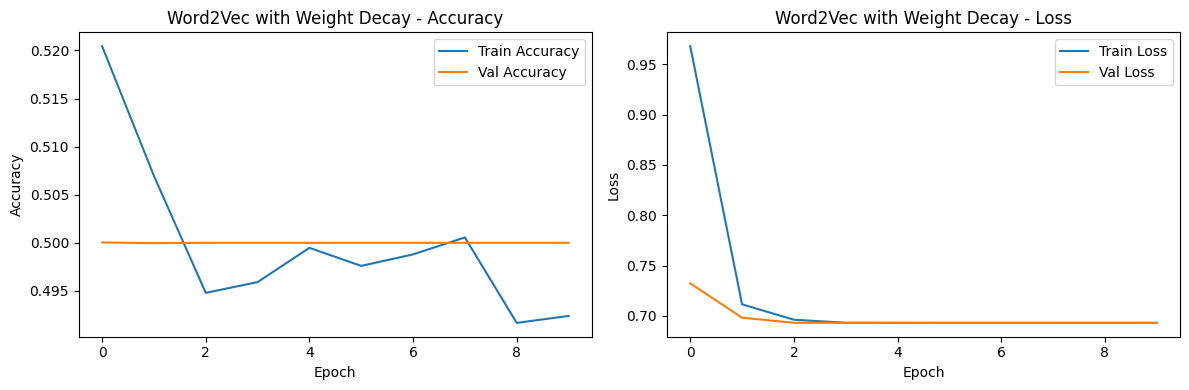

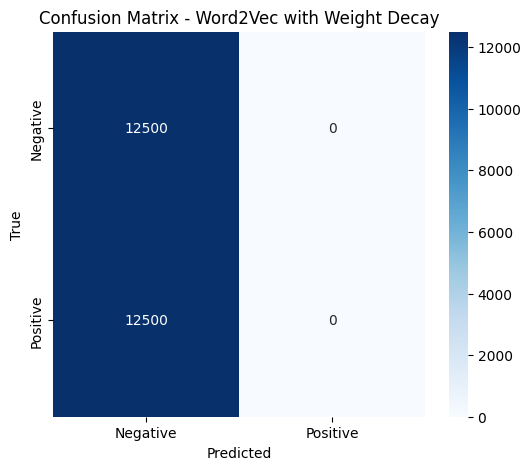

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 124ms/step - accuracy: 0.5530 - loss: 0.7233 - val_accuracy: 0.6128 - val_loss: 0.6579
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 101s 130ms/step - accuracy: 0.8135 - loss: 0.4222 - val_accuracy: 0.6039 - val_loss: 0.7830
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 130ms/step - accuracy: 0.9394 - loss: 0.1799 - val_accuracy: 0.5995 - val_loss: 1.1059
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 133s 118ms/step - accuracy: 0.9654 - loss: 0.0976 - val_accuracy: 0.6028 - val_loss: 1.2448
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 119ms/step - accuracy: 0.9721 - loss: 0.0827 - val_accuracy: 0.6031 - val_loss: 1.4057
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 149s 128ms/step - accuracy: 0.9735 - loss: 0.0717 - val_accuracy: 0.6051 - val_loss: 1.4438
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 128ms/step - accuracy: 0.9781 - loss: 0.0594 - val_accuracy: 0.6050 - val_loss: 1.6721
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 147s 134ms/step - accuracy: 0.9825 - loss: 0.05

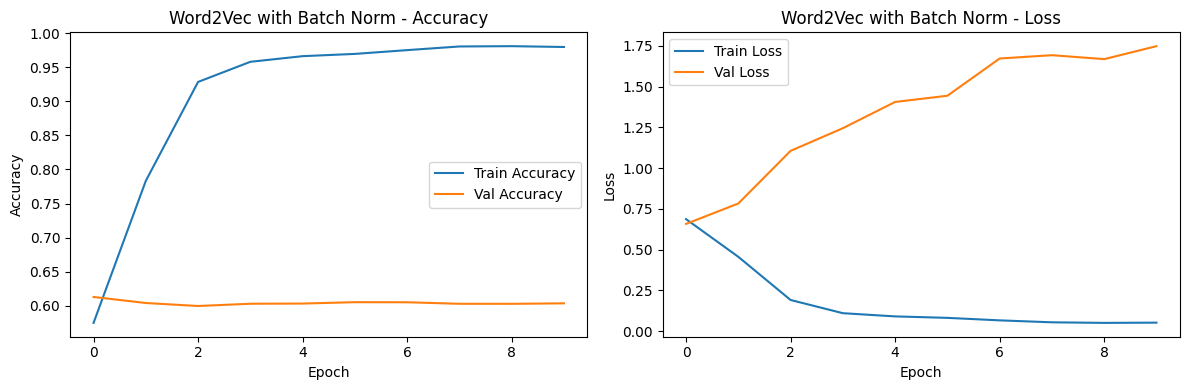

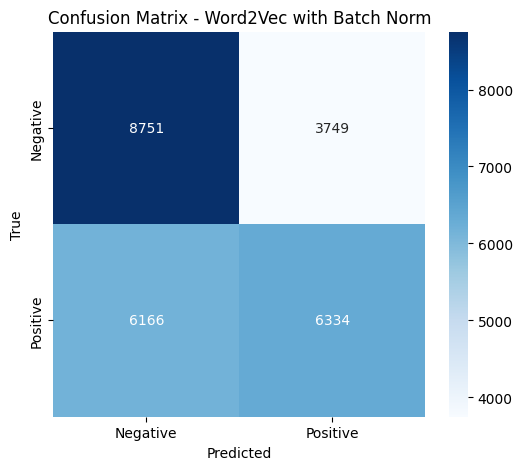


=== Summary of Results ===
Baseline TF-IDF: Train Acc = 1.0000, Test Acc = 0.8602
TF-IDF with Early Stopping: Train Acc = 0.9936, Test Acc = 0.8710
TF-IDF with Dropout: Train Acc = 0.9917, Test Acc = 0.8639
TF-IDF with Weight Decay: Train Acc = 0.8937, Test Acc = 0.8772
TF-IDF with Batch Norm: Train Acc = 0.9928, Test Acc = 0.8581
Baseline Word2Vec: Train Acc = 0.9908, Test Acc = 0.6080
Word2Vec with Early Stopping: Train Acc = 0.9645, Test Acc = 0.6168
Word2Vec with Dropout: Train Acc = 0.6275, Test Acc = 0.5521
Word2Vec with Weight Decay: Train Acc = 0.4924, Test Acc = 0.5000
Word2Vec with Batch Norm: Train Acc = 0.9799, Test Acc = 0.6034


In [ ]:
# Run all configurations and store results
#This reults with old configuration, which get unexpted results for two methods
results = {}
models = {}
for config_name, X_train_config, X_test_config, dropout, weight_decay, batch_norm, early_stopping, use_embedding in configs:
    train_acc, test_acc, y_pred, model = build_and_train_ann(
        X_train_config, X_test_config, y_train, y_test, config_name,
        use_dropout=dropout, use_weight_decay=weight_decay,
        use_batch_norm=batch_norm, use_early_stopping=early_stopping,
        use_embedding=use_embedding
    )
    results[config_name] = {'train_accuracy': train_acc, 'test_accuracy': test_acc, 'y_pred': y_pred}
    models[config_name] = model

# Print summary of results
print("\n=== Summary of Results ===")
for config_name, metrics in results.items():
    print(f"{config_name}: Train Acc = {metrics['train_accuracy']:.4f}, Test Acc = {metrics['test_accuracy']:.4f}")

In [ ]:
from tabulate import tabulate

# Print Table ANN Performance Across Configurations
print("\nTable: ANN Performance Across Configurations")
table_data = []
for config_name, result in results.items():
    table_data.append([
        config_name,
        f"{result['train_accuracy']:.4f}",
        f"{result['test_accuracy']:.4f}"
    ])

headers = ["Configuration", "Training Accuracy", "Test Accuracy"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))


Table: ANN Performance Across Configurations
+------------------------------+---------------------+-----------------+
| Configuration                |   Training Accuracy |   Test Accuracy |
+==============================+=====================+=================+
| Baseline TF-IDF              |              1      |          0.8602 |
+------------------------------+---------------------+-----------------+
| TF-IDF with Early Stopping   |              0.9936 |          0.871  |
+------------------------------+---------------------+-----------------+
| TF-IDF with Dropout          |              0.9917 |          0.8639 |
+------------------------------+---------------------+-----------------+
| TF-IDF with Weight Decay     |              0.8937 |          0.8772 |
+------------------------------+---------------------+-----------------+
| TF-IDF with Batch Norm       |              0.9928 |          0.8581 |
+------------------------------+---------------------+-----------------+
| Bas

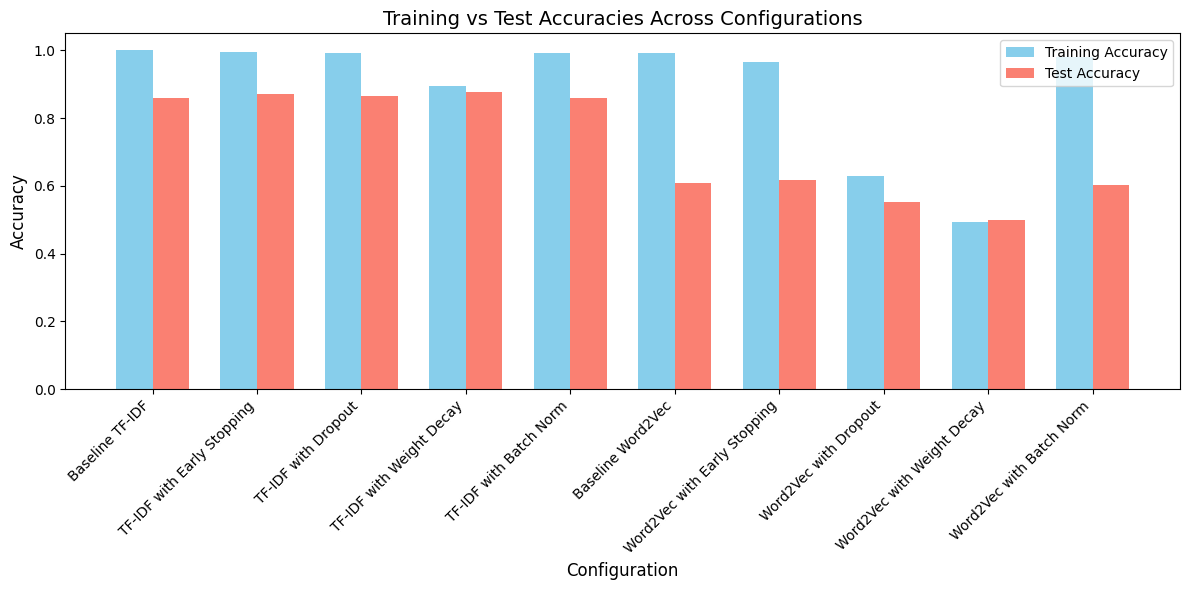

In [ ]:
# Add Grouped Bar Plot
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(results))

train_accuracies = [result['train_accuracy'] for result in results.values()]
test_accuracies = [result['test_accuracy'] for result in results.values()]

plt.bar(index, train_accuracies, bar_width, label='Training Accuracy', color='skyblue')
plt.bar(index + bar_width, test_accuracies, bar_width, label='Test Accuracy', color='salmon')

plt.xlabel('Configuration', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training vs Test Accuracies Across Configurations', fontsize=14)
plt.xticks(index + bar_width / 2, list(results.keys()), rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

**Results Word2Vec: 0.5–0.69 (Unexpected)**

To improve accuracy, the model was re-trained with updated configurations:

Epochs: Reduced from 10 to 5

Patience: Reduced from 5 to 3

Dropout: Adjusted from 0.5 to 0.3

**Impact of updates:**

Word2Vec accuracy improved from 0.5–0.69 to 0.83–0.85

TF accuracy still same range 0.85–0.87

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 90s 112ms/step - accuracy: 0.6621 - loss: 0.5748 - val_accuracy: 0.8518 - val_loss: 0.3390
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 98s 125ms/step - accuracy: 0.9715 - loss: 0.0902 - val_accuracy: 0.8188 - val_loss: 0.5492
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 121ms/step - accuracy: 0.9967 - loss: 0.0106 - val_accuracy: 0.8344 - val_loss: 0.7735
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 112ms/step - accuracy: 0.9985 - loss: 0.0038 - val_accuracy: 0.8300 - val_loss: 0.8808
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 147s 119ms/step - accuracy: 0.9958 - loss: 0.0121 - val_accuracy: 0.8344 - val_loss: 0.7915
Final Training Accuracy: 0.9947
Test Accuracy: 0.8344
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.86      0.84     12500
    Positive       0.85      0.81      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     2500

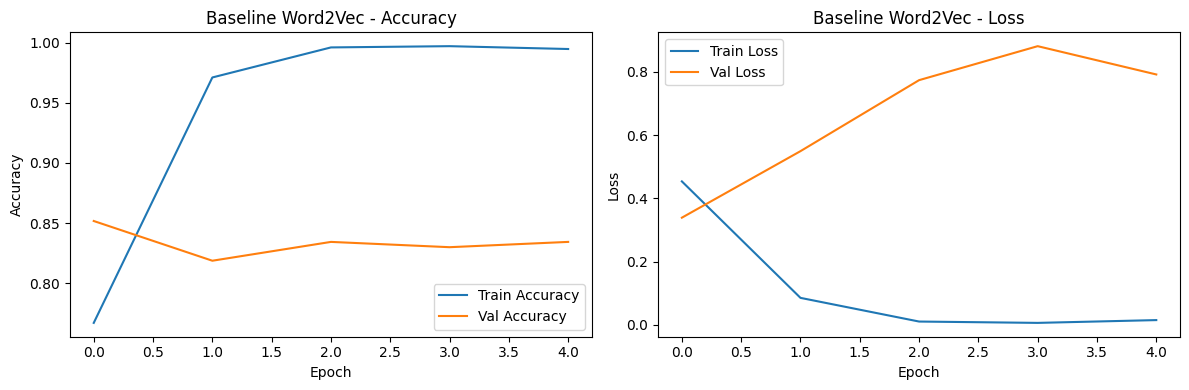

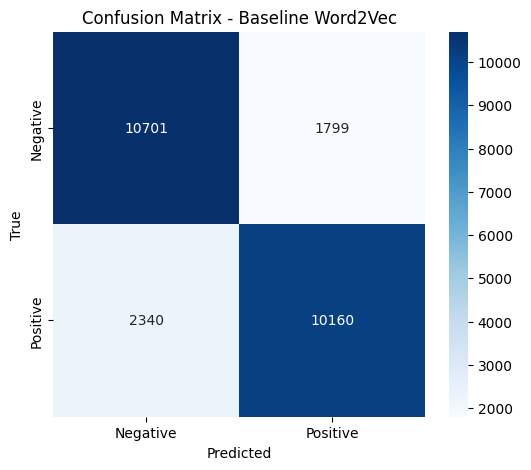

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 89s 112ms/step - accuracy: 0.6610 - loss: 0.5757 - val_accuracy: 0.8578 - val_loss: 0.3318
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.9705 - loss: 0.0895 - val_accuracy: 0.8427 - val_loss: 0.4652
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.9973 - loss: 0.0095 - val_accuracy: 0.8228 - val_loss: 0.8555
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 147s 113ms/step - accuracy: 0.9985 - loss: 0.0041 - val_accuracy: 0.8244 - val_loss: 0.7941
Final Training Accuracy: 0.9972
Test Accuracy: 0.8578
Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.80      0.85     12500
    Positive       0.82      0.91      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



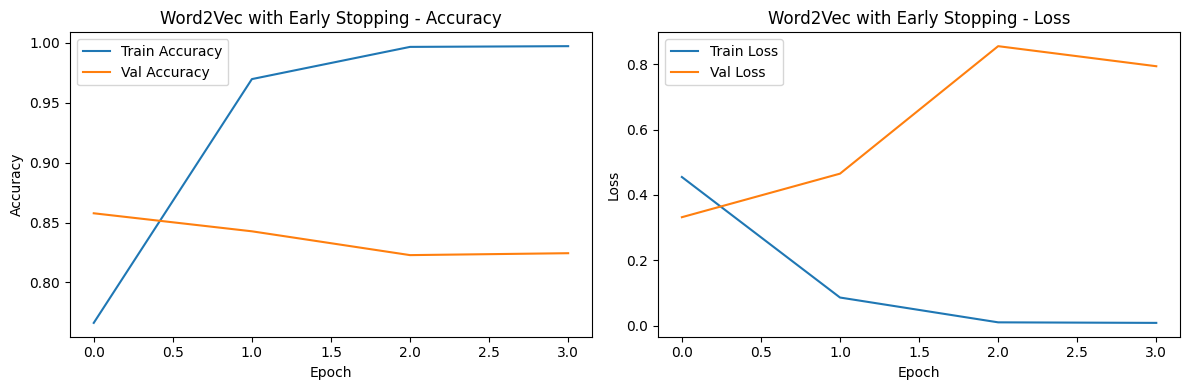

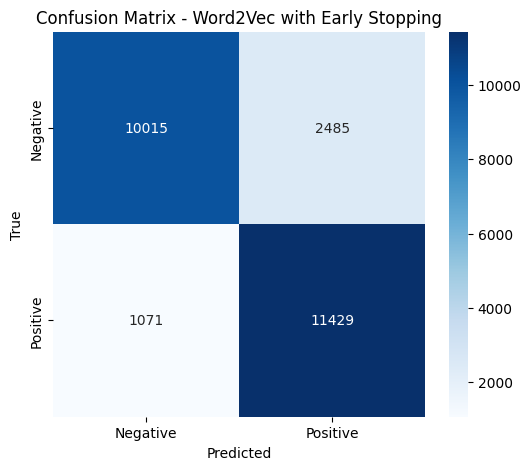

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 85s 106ms/step - accuracy: 0.5815 - loss: 0.6546 - val_accuracy: 0.8530 - val_loss: 0.3399
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 108ms/step - accuracy: 0.9189 - loss: 0.2169 - val_accuracy: 0.8409 - val_loss: 0.3652
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 120ms/step - accuracy: 0.9853 - loss: 0.0503 - val_accuracy: 0.8479 - val_loss: 0.5282
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 134s 110ms/step - accuracy: 0.9934 - loss: 0.0228 - val_accuracy: 0.8425 - val_loss: 0.7060
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 110ms/step - accuracy: 0.9953 - loss: 0.0156 - val_accuracy: 0.8444 - val_loss: 0.7730
Final Training Accuracy: 0.9942
Test Accuracy: 0.8444
Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.85      0.85     12500
    Positive       0.85      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted

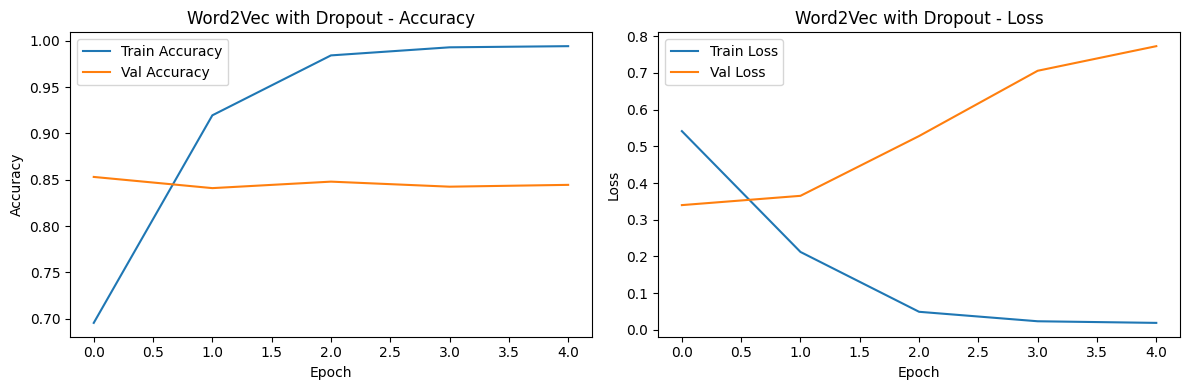

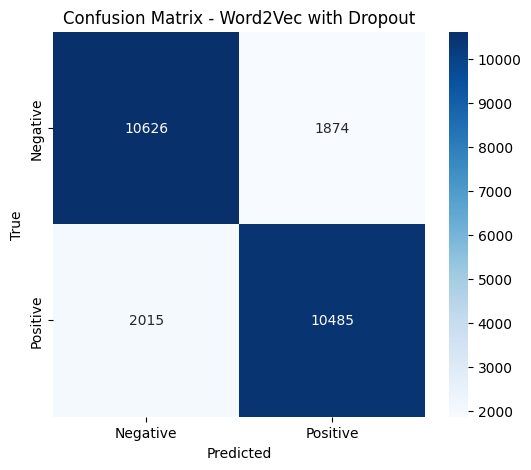

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 159s 137ms/step - accuracy: 0.6522 - loss: 0.8187 - val_accuracy: 0.8526 - val_loss: 0.4781
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 146s 141ms/step - accuracy: 0.9391 - loss: 0.3092 - val_accuracy: 0.8408 - val_loss: 0.5535
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 157s 161ms/step - accuracy: 0.9804 - loss: 0.1942 - val_accuracy: 0.8393 - val_loss: 0.6848
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 123s 157ms/step - accuracy: 0.9880 - loss: 0.1756 - val_accuracy: 0.8262 - val_loss: 0.7472
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 134s 147ms/step - accuracy: 0.9917 - loss: 0.1446 - val_accuracy: 0.8326 - val_loss: 0.7165
Final Training Accuracy: 0.9890
Test Accuracy: 0.8326
Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.83      0.83     12500
    Positive       0.83      0.84      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weight

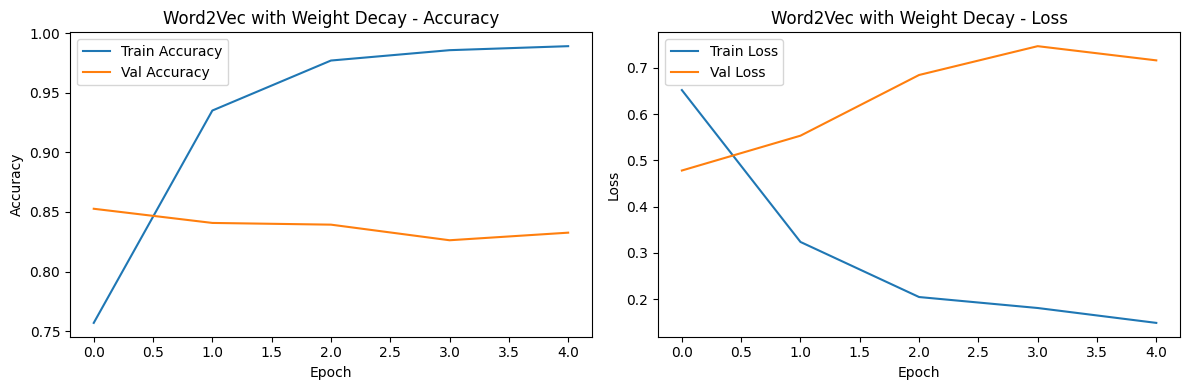

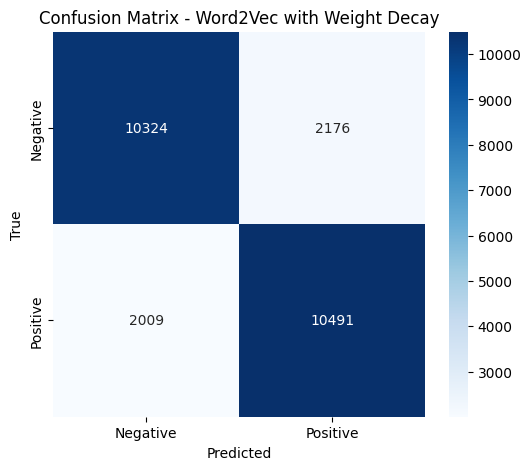

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - accuracy: 0.6149 - loss: 0.6464 - val_accuracy: 0.8346 - val_loss: 0.3687
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 128ms/step - accuracy: 0.9470 - loss: 0.1500 - val_accuracy: 0.8275 - val_loss: 0.4345
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 130ms/step - accuracy: 0.9852 - loss: 0.0503 - val_accuracy: 0.8106 - val_loss: 0.6184
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 130s 115ms/step - accuracy: 0.9915 - loss: 0.0253 - val_accuracy: 0.8133 - val_loss: 0.7041
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 149s 125ms/step - accuracy: 0.9905 - loss: 0.0277 - val_accuracy: 0.8335 - val_loss: 0.6781
Final Training Accuracy: 0.9892
Test Accuracy: 0.8335
Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.81      0.83     12500
    Positive       0.82      0.86      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weight

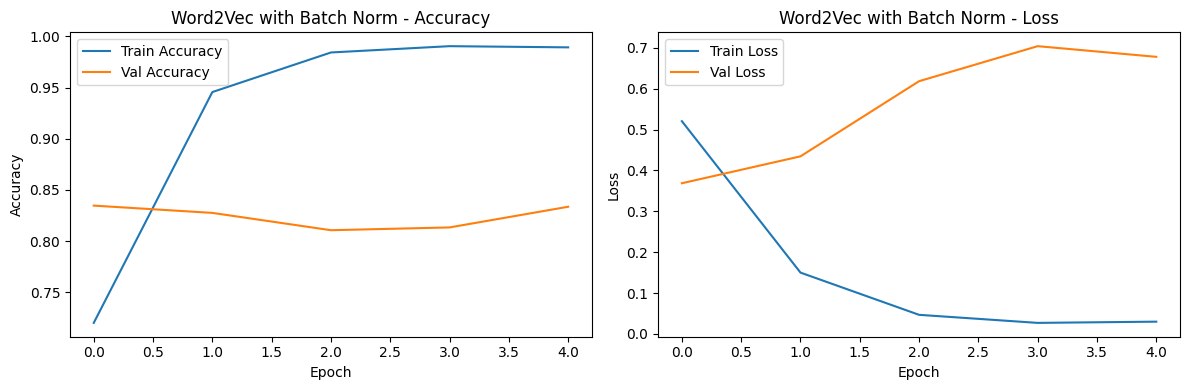

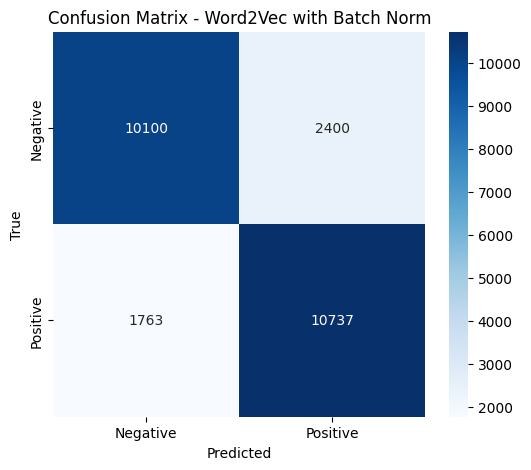


=== Summary of Results ===
Baseline Word2Vec: Train Acc = 0.9947, Test Acc = 0.8344
Word2Vec with Early Stopping: Train Acc = 0.9972, Test Acc = 0.8578
Word2Vec with Dropout: Train Acc = 0.9942, Test Acc = 0.8444
Word2Vec with Weight Decay: Train Acc = 0.9890, Test Acc = 0.8326
Word2Vec with Batch Norm: Train Acc = 0.9892, Test Acc = 0.8335


In [ ]:
# Test configurations for Word2Vec
configs = [

    ("Baseline Word2Vec", X_train_w2v, X_test_w2v, False, False, False, False, True),
    ("Word2Vec with Early Stopping", X_train_w2v, X_test_w2v, False, False, False, True, True),
    ("Word2Vec with Dropout", X_train_w2v, X_test_w2v, True, False, False, False, True),
    ("Word2Vec with Weight Decay", X_train_w2v, X_test_w2v, False, True, False, False, True),
    ("Word2Vec with Batch Norm", X_train_w2v, X_test_w2v, False, False, True, False, True),
]
# Run all configurations and store results
results = {}
models = {}
for config_name, X_train_config, X_test_config, dropout, weight_decay, batch_norm, early_stopping, use_embedding in configs:
    train_acc, test_acc, y_pred, model = build_and_train_ann(
        X_train_config, X_test_config, y_train, y_test, config_name,
        use_dropout=dropout, use_weight_decay=weight_decay,
        use_batch_norm=batch_norm, use_early_stopping=early_stopping,
        use_embedding=use_embedding
    )
    results[config_name] = {'train_accuracy': train_acc, 'test_accuracy': test_acc, 'y_pred': y_pred}
    models[config_name] = model

# Print summary of results
print("\n=== Summary of Results ===")
for config_name, metrics in results.items():
    print(f"{config_name}: Train Acc = {metrics['train_accuracy']:.4f}, Test Acc = {metrics['test_accuracy']:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8160 - loss: 0.3986 - val_accuracy: 0.8779 - val_loss: 0.2879
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9199 - loss: 0.2048 - val_accuracy: 0.8623 - val_loss: 0.3252
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9438 - loss: 0.1534 - val_accuracy: 0.8647 - val_loss: 0.3362
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9707 - loss: 0.0856 - val_accuracy: 0.8609 - val_loss: 0.4145
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9934 - loss: 0.0247 - val_accuracy: 0.8613 - val_loss: 0.6157
Final Training Accuracy: 0.9941
Test Accuracy: 0.8613
Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.87      0.86     12500
    Positive       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighte

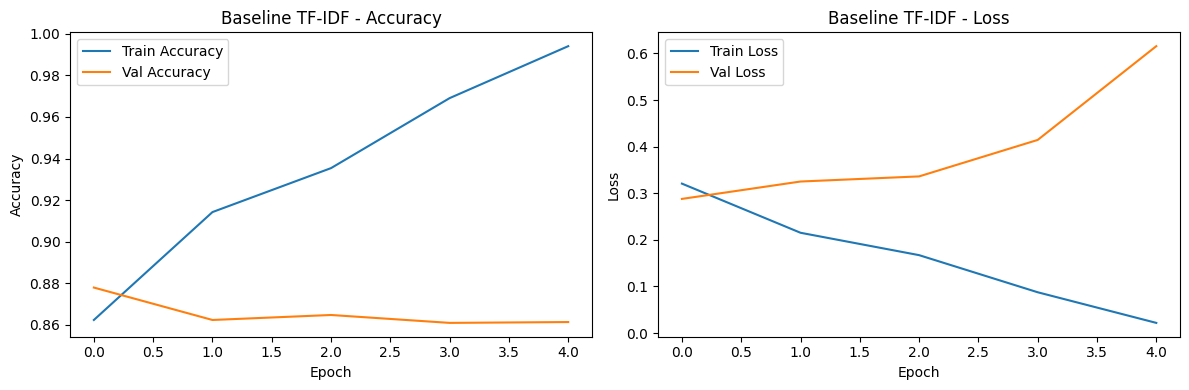

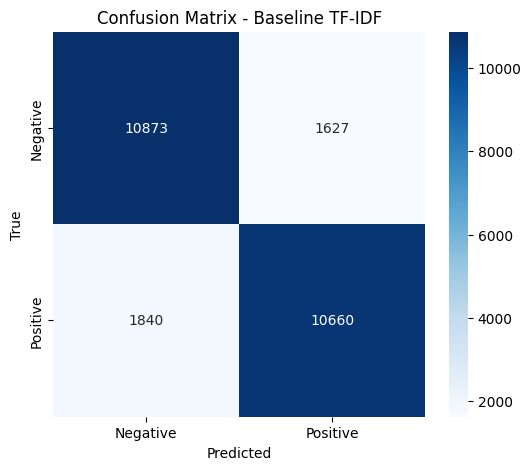

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8177 - loss: 0.4059 - val_accuracy: 0.8796 - val_loss: 0.2830
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.9243 - loss: 0.2004 - val_accuracy: 0.8690 - val_loss: 0.3042
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9444 - loss: 0.1501 - val_accuracy: 0.8682 - val_loss: 0.3432
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9715 - loss: 0.0837 - val_accuracy: 0.8623 - val_loss: 0.4273
Final Training Accuracy: 0.9694
Test Accuracy: 0.8796
Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88     12500
    Positive       0.87      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



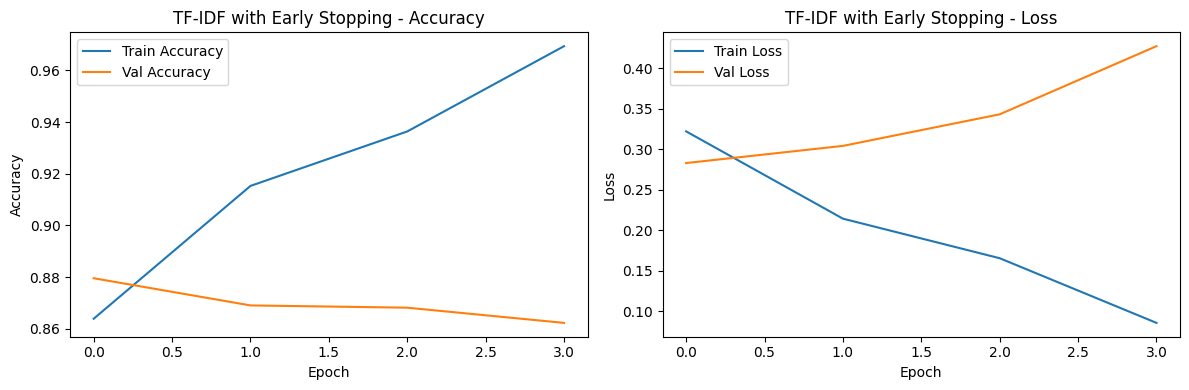

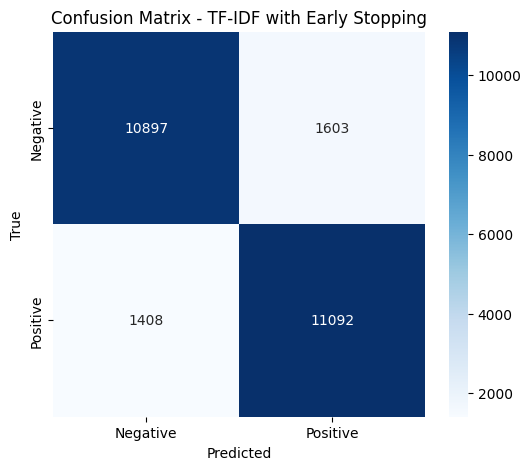

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7988 - loss: 0.4326 - val_accuracy: 0.8804 - val_loss: 0.2801
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9268 - loss: 0.1963 - val_accuracy: 0.8740 - val_loss: 0.3051
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9473 - loss: 0.1455 - val_accuracy: 0.8705 - val_loss: 0.3413
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9709 - loss: 0.0923 - val_accuracy: 0.8651 - val_loss: 0.4201
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9864 - loss: 0.0447 - val_accuracy: 0.8641 - val_loss: 0.5109
Final Training Accuracy: 0.9842
Test Accuracy: 0.8641
Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.86     12500
    Positive       0.86      0.87      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted 

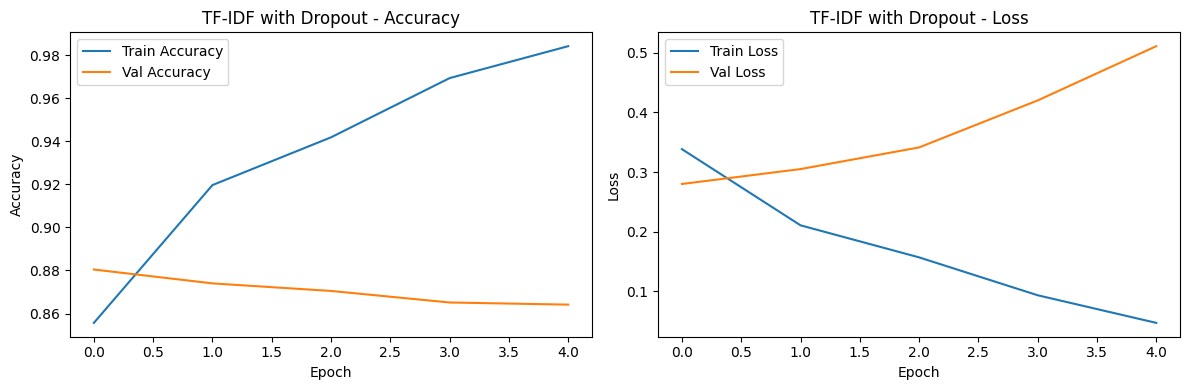

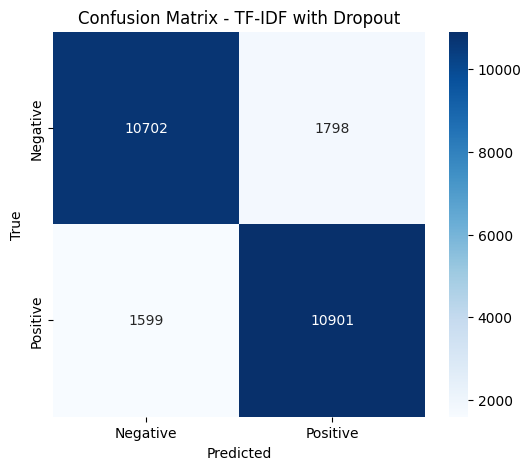

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8122 - loss: 0.5547 - val_accuracy: 0.8671 - val_loss: 0.4234
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8895 - loss: 0.3844 - val_accuracy: 0.8650 - val_loss: 0.4090
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8949 - loss: 0.3587 - val_accuracy: 0.8729 - val_loss: 0.3861
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9009 - loss: 0.3376 - val_accuracy: 0.8738 - val_loss: 0.3727
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9093 - loss: 0.3133 - val_accuracy: 0.8751 - val_loss: 0.3653
Final Training Accuracy: 0.9003
Test Accuracy: 0.8751
Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.88     12500
    Positive       0.89      0.86      0.87     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighte

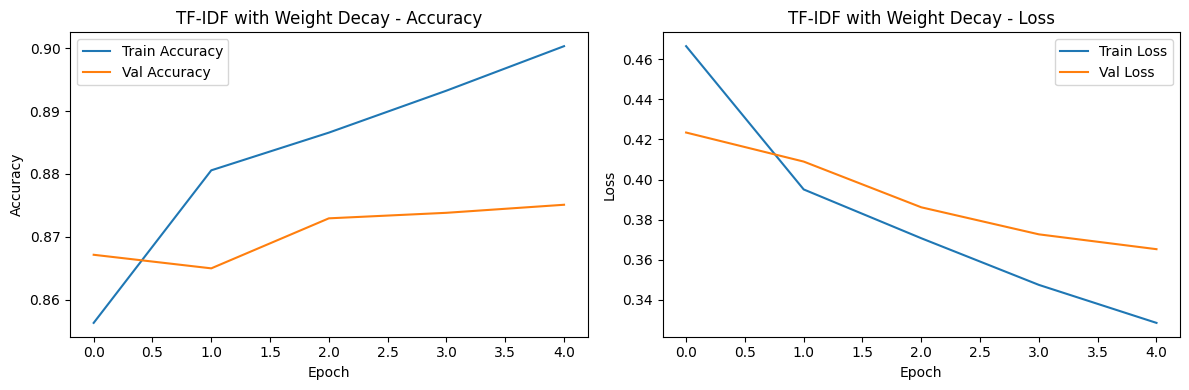

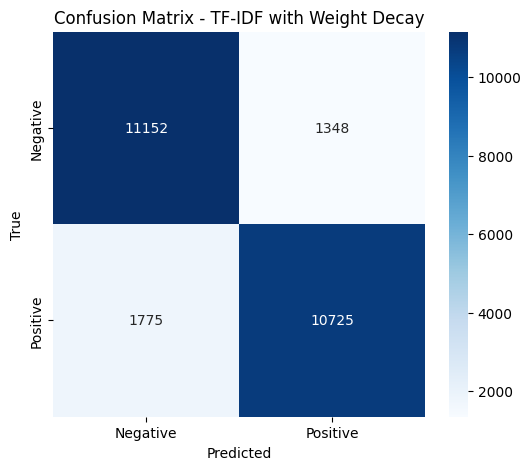

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.8095 - loss: 0.4098 - val_accuracy: 0.8734 - val_loss: 0.2952
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9415 - loss: 0.1589 - val_accuracy: 0.8632 - val_loss: 0.3618
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9774 - loss: 0.0688 - val_accuracy: 0.8553 - val_loss: 0.4516
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9871 - loss: 0.0393 - val_accuracy: 0.8530 - val_loss: 0.4922
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9887 - loss: 0.0341 - val_accuracy: 0.8530 - val_loss: 0.5138
Final Training Accuracy: 0.9865
Test Accuracy: 0.8530
Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85     12500
    Positive       0.85      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weight

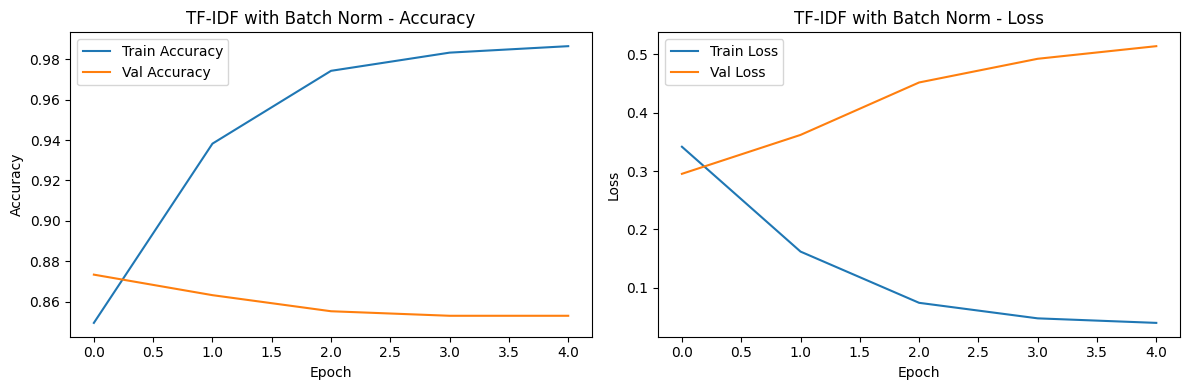

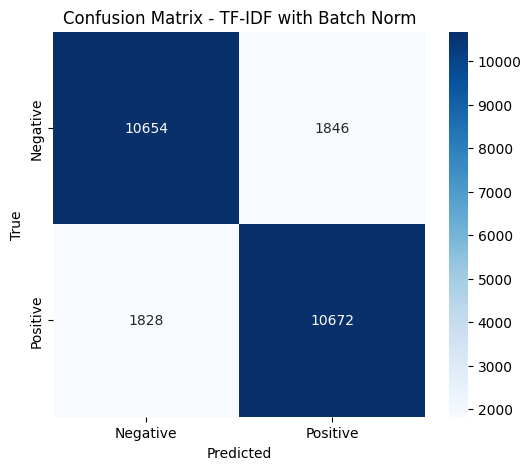


=== Summary of Results TF-IDF ===
Baseline TF-IDF: Train Acc = 0.9941, Test Acc = 0.8613
TF-IDF with Early Stopping: Train Acc = 0.9694, Test Acc = 0.8796
TF-IDF with Dropout: Train Acc = 0.9842, Test Acc = 0.8641
TF-IDF with Weight Decay: Train Acc = 0.9003, Test Acc = 0.8751
TF-IDF with Batch Norm: Train Acc = 0.9865, Test Acc = 0.8530


In [ ]:
# Test configurations for TF-IDF
configs = [

    ("Baseline TF-IDF", X_train_tfidf, X_test_tfidf, False, False, False, False, False),
    ("TF-IDF with Early Stopping", X_train_tfidf, X_test_tfidf, False, False, False, True, False),
    ("TF-IDF with Dropout", X_train_tfidf, X_test_tfidf, True, False, False, False, False),
    ("TF-IDF with Weight Decay", X_train_tfidf, X_test_tfidf, False, True, False, False, False),
    ("TF-IDF with Batch Norm", X_train_tfidf, X_test_tfidf, False, False, True, False, False)
]
# Run all configurations and store results
results = {}
models = {}
for config_name, X_train_config, X_test_config, dropout, weight_decay, batch_norm, early_stopping, use_embedding in configs:
    train_acc, test_acc, y_pred, model = build_and_train_ann(
        X_train_config, X_test_config, y_train, y_test, config_name,
        use_dropout=dropout, use_weight_decay=weight_decay,
        use_batch_norm=batch_norm, use_early_stopping=early_stopping,
        use_embedding=use_embedding
    )
    results[config_name] = {'train_accuracy': train_acc, 'test_accuracy': test_acc, 'y_pred': y_pred}
    models[config_name] = model

# Print summary of results
print("\n=== Summary of Results TF-IDF ===")
for config_name, metrics in results.items():
    print(f"{config_name}: Train Acc = {metrics['train_accuracy']:.4f}, Test Acc = {metrics['test_accuracy']:.4f}")

In [ ]:
print("X_train_w2v shape:", X_train_w2v.shape)  # Should be (25000, 200)
print("y_train shape:", y_train.shape)  # Should be (25000,)
model.summary()

X_train_w2v shape: (25000, 200)
y_train shape: (25000,)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 128)                 │         640,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,946,885 (7.43 MB)

 Trainable params: 648,833 (2.48 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 1,297,668 (4.95 MB)

In [ ]:
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Unique labels in y_train: {np.unique(y_train)}")
print(f"Unique labels in y_test: {np.unique(y_test)}")

Training samples: 25000, Test samples: 25000
Unique labels in y_train: [0 1]
Unique labels in y_test: [0 1]


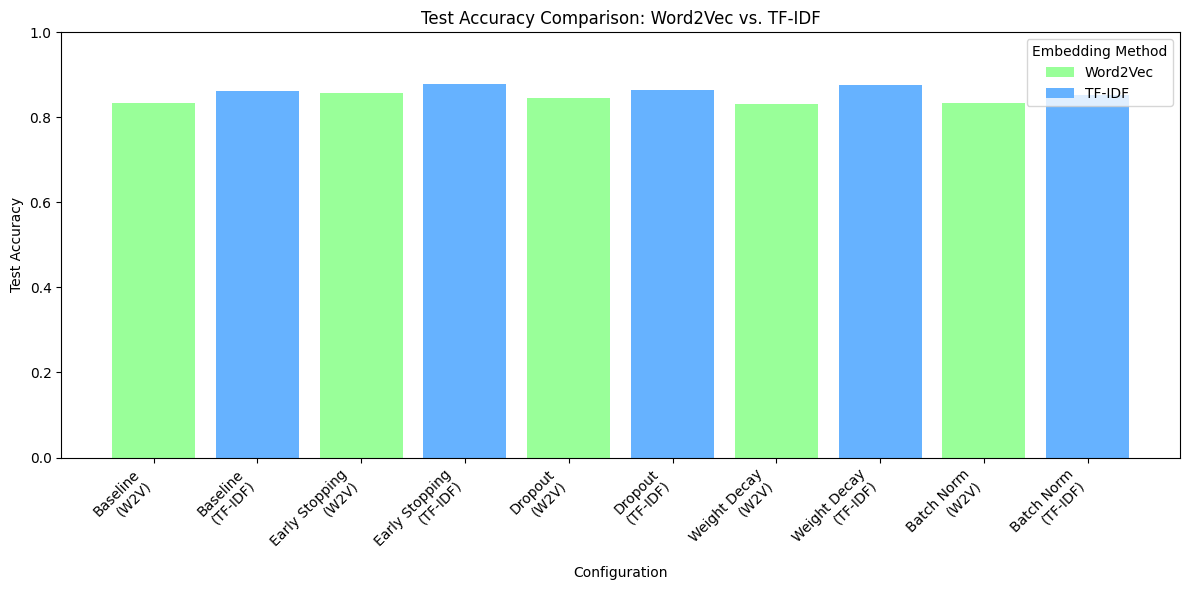

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Data from the table
configurations = [
    "Baseline",
    "Early Stopping",
    "Dropout",
    "Weight Decay",
    "Batch Norm"
]

test_acc_w2v = [0.8344, 0.8578, 0.8444, 0.8326, 0.8335]  # Test Acc for W2V
test_acc_tfidf = [0.8613, 0.8796, 0.8641, 0.8751, 0.8530]  # Test Acc for TF-IDF

# Combine method names for the x-axis labels
methods_w2v = [f"{config}\n(W2V)" for config in configurations]
methods_tfidf = [f"{config}\n(TF-IDF)" for config in configurations]
all_labels = []
for w2v, tfidf in zip(methods_w2v, methods_tfidf):
    all_labels.append(w2v)
    all_labels.append(tfidf)

# Combine test accuracies for plotting
all_test_acc = []
for w2v_acc, tfidf_acc in zip(test_acc_w2v, test_acc_tfidf):
    all_test_acc.append(w2v_acc)
    all_test_acc.append(tfidf_acc)

# Colors for W2V and TF-IDF
colors = []
for _ in range(len(configurations)):
    colors.append('#99FF99')  # W2V
    colors.append('#66B2FF')  # TF-IDF

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(all_labels, all_test_acc, color=colors)
plt.xlabel('Configuration')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison: Word2Vec vs. TF-IDF')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Add legend
legend_elements = [
    Patch(facecolor='#99FF99', label='Word2Vec'),
    Patch(facecolor='#66B2FF', label='TF-IDF')
]
plt.legend(handles=legend_elements, title='Embedding Method')

plt.tight_layout()
plt.show()